In [ ]:
import os
os.kill(os.getpid(), 9)


# <font color = 'Hotpink'>**Multilabel Classification Using Gemma**

- The purpose of this notebook is to finetune the Gemma 2b model for emotion detection on a small dataset.

- Based on my past experiences using both RNN and BERT models I plan on using a similar strategy to account for the class imbalance present in this dataset.

- This will be done using K fold stratified sampling to create my splits such that the class distribution represents that of the training set.

- In addition I plan on accounting for the class imbalance by calculating some class weights and including thresholding to see how this model performs in comparison to my previous attempts.

- The training will follow a standard model training process as shown below.

## <font color='hotpink'>**Training Plan**

1. **Set the Environment**

2. **Load the Dataset**

3. **Manipulate the Splits of the Dataset**

4. **Load the Pretrained Tokenizer**

5. **Create a Function for the Tokenizer**

6. **Train the Model**
   - 6.1. Download the model
   - 6.2. Download and modify the model's config file
   - 6.3. Compute the metric function (ensuring we account for multilabel, e.g., Binary Cross Entropy)
   - 6.4. Define Training Arguments
   - 6.5. Instantiate the Trainer
   - 6.6. Setup Weights & Biases (WANDB)
   - 6.7. Training and Validation

7. **Model Inference**


# <font color='hotpink'>**1. Setting the Environment**

In [ ]:
import sys

# Check if running in Google Colab
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    # Mount Google Drive with force_remount to avoid mounting issues
    drive.mount('/content/drive', force_remount=True)

    # Set the base path to a Google Drive folder
    base_path = '/content/drive/MyDrive/Colab Notebooks'

    # Install necessary packages
    print("Installing required libraries...")
    !pip install transformers evaluate wandb datasets accelerate peft bitsandbytes -U -qq
    !pip install iterative-stratification -qq

    print("All packages installed successfully.")

# No need to force restart the runtime as this approach aligns with Colab's auto-resolved environment



Mounted at /content/drive
Installing required libraries...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 111.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
All packages installed succ

<font color = 'hotpink'>***Loading Neccessary Libraries***

## Why Use `ninja-build` for GEMMA-2B Multilabel Fine-tuning in Colab

When fine-tuning a **large language model** like GEMMA-2B for **multilabel classification**, especially in Google Colab, it pays to streamline your setup. Here’s why adding `ninja-build` into the mix can be a game-changer:

### 🚀 Speeding Things Up
- GEMMA-2B has a lot going on under the hood, like **compiling custom layers** and CUDA extensions.
- `ninja-build` is all about speed—it **compiles code way faster** than older tools like `make`, cutting down on wait times.

### 🧩 Plays Nice with Libraries
- Libraries like `transformers` and `peft` might **automatically leverage** `ninja-build` if it's installed, speeding up their setup.
- If your fine-tuning involves any **native code or CUDA optimizations**, this can be a lifesaver.

### 🛠️ Keeping Things Smooth
- Fine-tuning big models like GEMMA-2B can be resource-heavy. Using `ninja-build` helps keep everything **running smoothly**, avoiding those annoying compile-time errors or slowdowns.

### How to Install It
```bash
!apt-get install -y ninja-build


In [ ]:
# useful for building and compiling code for GPU and Pytorch extensions
!apt-get install -y ninja-build

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  ninja-build
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 111 kB of archives.
After this operation, 358 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 ninja-build amd64 1.10.1-1 [111 kB]
Fetched 111 kB in 0s (264 kB/s)
Selecting previously unselected package ninja-build.
(Reading database ... 123629 files and directories currently installed.)
Preparing to unpack .../ninja-build_1.10.1-1_amd64.deb ...
Unpacking ninja-build (1.10.1-1) ...
Setting up ninja-build (1.10.1-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import (
    confusion_matrix,
    multilabel_confusion_matrix,
    precision_score,
    recall_score,
    f1_score
    )

from pathlib import Path
import numpy as np

import re
import gc
import time

from sklearn.preprocessing import MultiLabelBinarizer
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import joblib

# Huggingface, wandb, torch, bitsandbytes, transformers
import evaluate
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
from transformers import (
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    AutoModelForSequenceClassification,
    AutoConfig,
    pipeline,
    BitsAndBytesConfig,
    set_seed
    )

from peft import (
    TaskType,
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model
)

import wandb
from google.colab import userdata
from huggingface_hub import login
import torch.nn as nn
import ast
import torch


In [ ]:
set_seed(42)

In [ ]:
wandb_api_key = userdata.get('WANDB_API_KEY')
hf_token = userdata.get('HF_TOKEN')

In [ ]:
if hf_token:
  login(token = hf_token)
  print('Login Successful')
else:
  print('HF login not unsuccessful - Missing token')


Login Successful


In [ ]:
if wandb_api_key:
  wandb.login(key = wandb_api_key)
  print('Login Successful')
else:
  print('Login Unsuccessful')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Login Successful


In [ ]:
# Designating paths for saving and loading
base_folder = Path(base_path)
data_folder = base_folder/'datasets/emotion_detection_ds'
model_folder = base_folder/'models/nlp_fall_2024/gemma2b'

model_folder.mkdir(exist_ok = True, parents = True)

# <font color='hotpink'>**2. Loading the Dataset**

In [ ]:
train_valid_df = pd.read_csv(data_folder/'train.csv')
train_valid_df.head(5)

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


In [ ]:
train_val_labels = train_valid_df[['anger',
                                      'anticipation',
                                             'disgust',
                                             'fear',
                                             'joy',
                                             'love',
                                             'optimism',
                                             'pessimism',
                                             'sadness',
                                             'surprise',
                                             'trust']]

<font color = 'hotpink'>***Plotting to show imbalance***

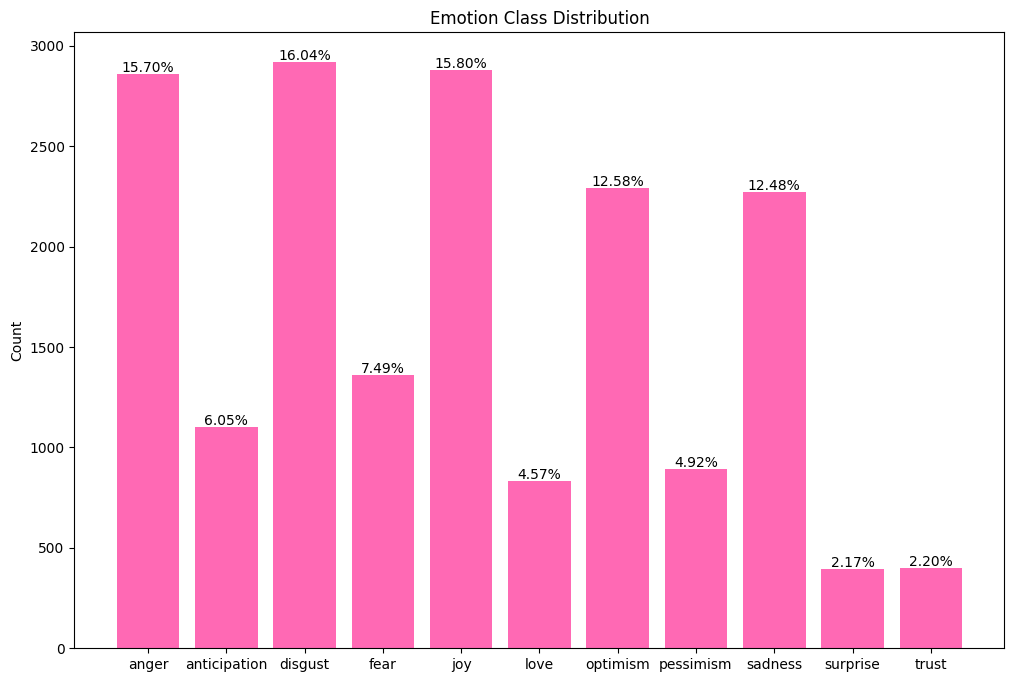

In [ ]:
# Sums of each label
label_counts = train_val_labels.sum()

# Total sum of all labels
total_counts  = label_counts.sum()

# getting the percentages for each label
percentages = (label_counts/total_counts)*100

# plotting a bar plot
plt.figure(figsize = (12,8))
plt.bar(label_counts.index, label_counts.values, color = 'hotpink')

for i, (count, pct) in enumerate (zip(label_counts.values,percentages)):
  plt.text(i, count+10, f'{pct:.2f}%',  ha = 'center')

plt.title('Emotion Class Distribution')
plt.ylabel('Count')
plt.show()


In [ ]:
label_counts

,0
anger,2859
anticipation,1102
disgust,2921
fear,1363
joy,2877
love,832
optimism,2291
pessimism,895
sadness,2273
surprise,396


# <font color='hotpink'>**3. Splitting and Preparing the Data**

 <font color='hotpink'>***Applying Multilabel Stratified KFold***

In [ ]:
# importing the splitter
mkf = MultilabelStratifiedKFold(n_splits = 10, shuffle = True, random_state = 42) # shuffling and doing 10 splits

X = train_valid_df['Tweet'].values
y = train_val_labels.values

# designating indices for the training and validation set
for train_index, val_index in mkf.split(X, y):
  X_train, X_val = X[train_index], X[val_index]
  y_train, y_val  = y[train_index], y[val_index]





In [ ]:
# Reformatting to dataframe
train_df = train_valid_df.iloc[train_index] # pulling the training indices from split
val_df = train_valid_df.iloc[val_index] # pulling thre val indices from split



In [ ]:
train_df.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


In [ ]:
val_df.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
6,2017-20221,Do you think humans have the sense for recogni...,0,1,0,0,0,0,0,1,0,0,0
25,2017-11184,What a fucking muppet. @jRwild1 #stalker.,1,0,1,0,0,0,0,0,0,0,0
28,2017-21740,@FaithHill I remember it well #happy #afraid #...,0,0,0,1,1,1,1,0,0,0,0
31,2017-21716,@WaterboysAS I would never strategically vote ...,1,0,1,1,0,0,0,0,0,0,0
39,2017-21752,@imtarakate Uggh that's really horrible. You'r...,0,0,1,1,0,0,1,0,0,0,1


In [ ]:
train_labels = train_df[['anger',
                         'anticipation',
                         'disgust',
                         'fear',
                         'joy',
                         'love',
                         'optimism',
                         'pessimism',
                         'sadness',
                         'surprise',
                         'trust']]

In [ ]:
train_labels.sum()

,0
anger,2574
anticipation,991
disgust,2629
fear,1226
joy,2589
love,749
optimism,2062
pessimism,805
sadness,2046
surprise,356


### <font color = 'hotpink'>***The plots below shows how the stratified sampling split properly represents the full training set.***

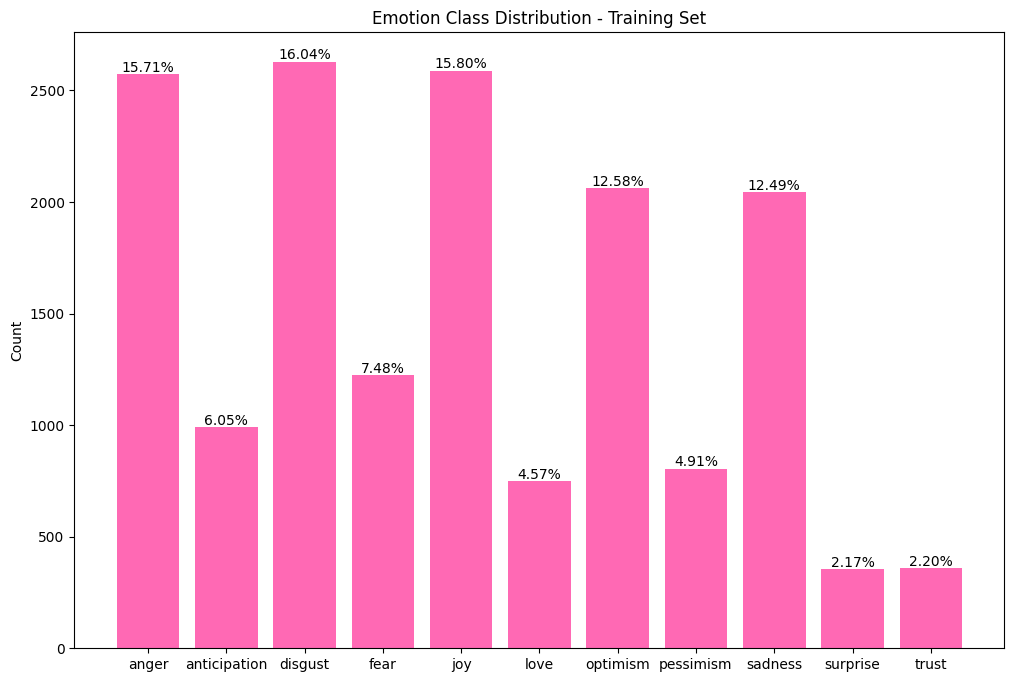

In [ ]:
# plotting of class distribution - Training Set
label_counts_t = train_labels.sum()

# Total label counts
total_counts = label_counts_t.sum()

# percentage calculations
percentages = (label_counts_t/total_counts)*100

# Making a bar plot
plt.figure(figsize = (12,8))
plt.bar(label_counts_t.index, label_counts_t.values, color = 'hotpink')

# Adding labels for the percentages
for i, (count, pct) in enumerate(zip(label_counts_t.values, percentages)):
  plt.text(i, count + 10 , f'{pct:.2f}%',  ha = 'center' )


plt.title('Emotion Class Distribution - Training Set')
plt.ylabel('Count')
plt.show()

In [ ]:
val_labels = val_df[['anger',
                         'anticipation',
                         'disgust',
                         'fear',
                         'joy',
                         'love',
                         'optimism',
                         'pessimism',
                         'sadness',
                         'surprise',
                         'trust']]

In [ ]:
val_labels.sum()

,0
anger,285
anticipation,111
disgust,292
fear,137
joy,288
love,83
optimism,229
pessimism,90
sadness,227
surprise,40


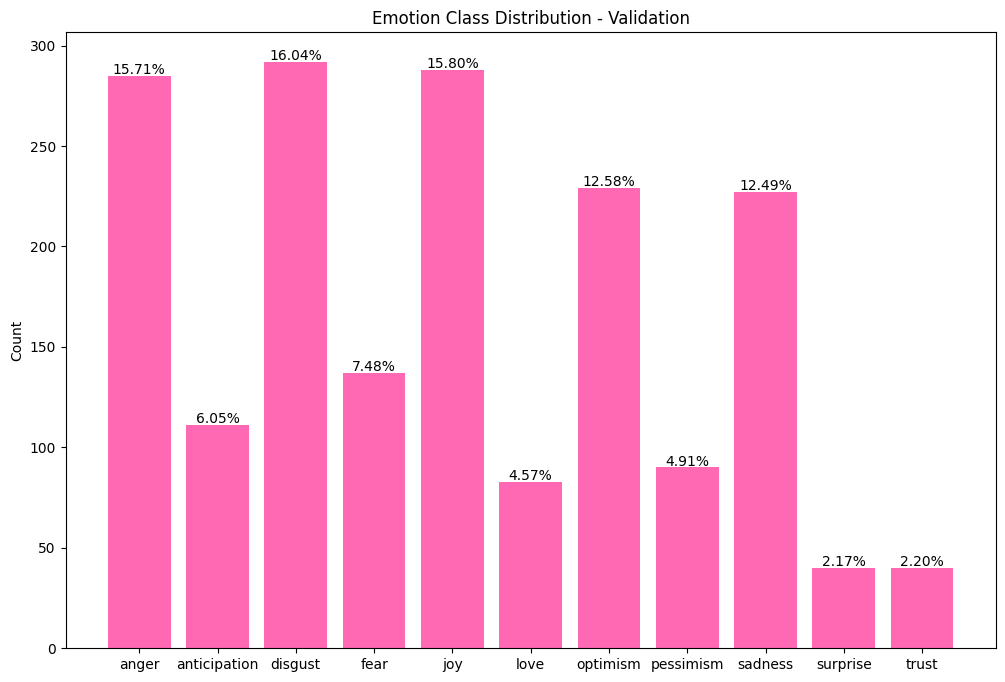

In [ ]:
# getting label counts
label_count_v = val_labels.sum()

# total counts
total_count = label_count_v.sum()

# percentages
percentages_val = (label_count_v/total_count)*100

# plotting the figure
plt.figure(figsize = (12,8))
plt.bar(label_count_v.index, label_count_v.values, color = 'hotpink')

for i, (count, pct) in enumerate(zip(label_count_v.values, percentages_val)):
  plt.text(i, count + 1, f'{pct:.2f}%', ha = 'center')

plt.title('Emotion Class Distribution - Validation')
plt.ylabel('Count')
plt.show()

In [ ]:
type(X_train)

numpy.ndarray

In [ ]:
type(y_train)

numpy.ndarray

In [ ]:
# converting the features from the datasets to list
X_train = X_train.tolist()
X_val = X_val.tolist()

In [ ]:
X_val[0]

'Do you think humans have the sense for recognizing impending doom? '

<font color = 'hotpink'>***Initial Datasets***

In [ ]:
trainset = Dataset.from_dict(
    {'text':X_train, 'label':y_train}
)

validset = Dataset.from_dict(
    {'text':X_val, 'label': y_val}
)

In [ ]:
trainset

Dataset({
    features: ['text', 'label'],
    num_rows: 6951
})

In [ ]:
trainset['text'][:5]

["“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry",
 'Whatever you decide to do make sure it makes you #happy.',
 "@Max_Kellerman  it also helps that the majority of NFL coaching is inept. Some of Bill O'Brien's play calling was wow, ! #GOPATS",
 "Accept the challenges so that you can literally even feel the exhilaration of victory.' -- George S. Patton 🐶",
 "My roommate: it's okay that we can't spell because we have autocorrect. #terrible #firstworldprobs"]

In [ ]:
trainset['label'][:5]

[[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1],
 [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
 [1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]]

In [ ]:
validset['text'][3:5]

["@WaterboysAS I would never strategically vote for someone I don't agree with. A lot of the Clinton vote based on fear and negativity.",
 "@imtarakate Uggh that's really horrible. You're not a bad person by any stretch of the imagination. I hope this person realizes that."]

In [ ]:
validset['label'][3:5]

[[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1]]

<font color = 'hotpink'>***Final Dataset***

In [ ]:
# compiling both the trainset and validset into one dictionary
train_val = DatasetDict({'train':trainset, 'valid':validset})


In [ ]:
train_val

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6951
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 773
    })
})

In [ ]:
# pulling the first 5 labels from the trainset portion of train_val
train_val['train']['label'][:5]

[[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1],
 [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
 [1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]]

In [ ]:
# pulling the labels from 3:5 in the validset portion of train_val
train_val['valid']['label'][3:5]

[[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1]]

# <font color='hotpink'>**4. Initializing the Pretrained Tokenizer**


## <font color='hotpink'>**Loading the Gemma-2b tokenizer**

### The difference between BERT and a QLoRA model:
- **BERT** (Bidirectional Encoder Representations from Transformers) is a transformer-based model that focuses on two key tasks:
  - **Masked Language Modeling**: BERT randomly masks 15% of tokens in the input sequence, and the model learns to predict the masked tokens, which helps it understand context better.
  - **Next Sentence Prediction**: BERT is trained to predict whether two sentences follow each other in a given pair (e.g., "Is sentence A followed by sentence B?").
  - BERT can handle many different tasks, but these two are the main pretraining objectives.

- **QLoRA** (Quantized Low-Rank Adaptation):
  - QLoRA is an efficient, lightweight approach to fine-tuning LLM's using quantized weights and low-rank adaptors.
    - <font color = 'hotpink'>**Quantization**</font> reduces the precision of values by changing the way numbers are used within the model.
    - Standard models use 32-bit floating point numbers to represent the weights of a model.
    - Quantized weights are represented in lower formats such as 8-bit or 4-bit representations.
      - By using fewer bits to store the same data, quantization allows models to:
        - Use less memory
        - Run faster on existing hardware
        - Consume less power, which makes them more efficient for deployment.
    - QLoRA, in particular, uses 4-bit quantization to compress LLM's while maintaining performance at the same time.
      - This means we can fit a large language model into the memory of a 24GB GPU!
    - <font color = 'hotpink'>**Low Rank adaptation**</font> works by freezing the original model weights.
      - Instead of taking the entire weight matrix from the original model we fine tune two smaller matrices of weights and add them to the original weight matrix.
      - Example:

        Weights = Main_weights + Small_matrix_A*Small_matrix_B

        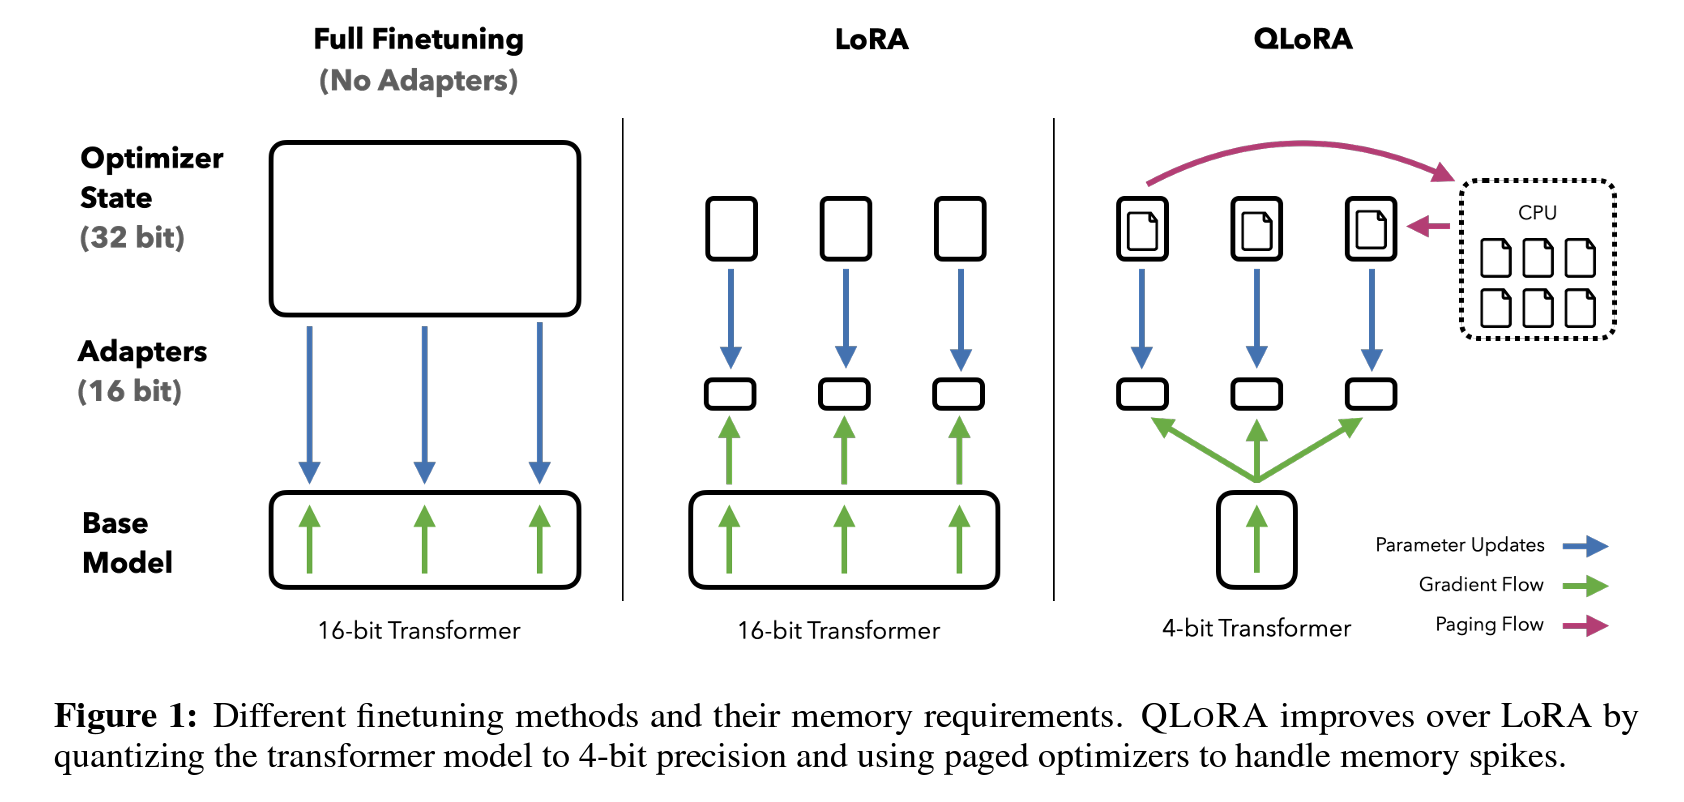

      [Original QLoRA Paper](https://arxiv.org/abs/2305.14314)
      - This allows for a finetuning process that is much smaller and efficient.
      



In [ ]:
def free_gpu_memory():
  """
  Frees up gpu memory after CUDA out of memory error in Colab.

  This function performs the following steps:
  1. Deletes all pytorch objects.
  2. Calls garbage collection to remove unreferenced objects.
  3. Uses torch.cuda.empy_cache() to release cached GPU memory
  4. Waits for a moment to ensure memory is fully released.
  """

  try:
    # Delete all torch tensors to free uo memory
    for obj in list(locals().values()):
      if torch.is_tensor(obj):
        del obj

    # collecting garbage to release any remaining unused memory
    gc.collect()

    # empty the CUDA chache to release GPU memory
    torch.cuda.empty_cache()

    # adding a small delay to allow memory to be fully released
    time.sleep(2)

    print("GPU memory has been freed.")
  except Exception as e:
    print(f"Error while freeing GPU memory: {e}")


In [ ]:
free_gpu_memory()

GPU memory has been freed.


In [ ]:
# pulling in the gemma model checkpoint
checkpoint = 'google/gemma-2-2b'
# setting the tokenizer
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

# <font color='hotpink'>**5. Creating the Tokenization Function**

In [ ]:
def tokenize_fn(batch):
  return tokenizer(text = batch['text'], truncation = True, max_length = 512, padding = True)

<font color = 'hotpink'>***Mapping to apply the tokenizer to all splits***

In [ ]:
# mapping the function to every batch
tokenized_dataset = train_val.map(tokenize_fn, batched = True)
# post tokenization removing the full text column
tokenized_dataset = tokenized_dataset.remove_columns(
    ['text']

)

# setting the format to torch tensors
tokenized_dataset.set_format(type = 'torch')


Map:   0%|          | 0/6951 [00:00<?, ? examples/s]

Map:   0%|          | 0/773 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 6951
    })
    valid: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 773
    })
})

In [ ]:
tokenized_dataset['train'][0]

{'label': tensor([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]),
 'input_ids': tensor([     0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      2, 235366, 235325,
           8433,    603,    476,   1706,   7984,    611,    476,   3210,    692,
           1249,   2447,    791,   6036,  84306, 110771,  35027, 235265,    139,
         235345, 171521,   1700, 126813,   1700, 232495]),
 'attention_mask': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}

#### <font color='hotpink'>**Remapping labels to float**

- In the code below, I call a `map` function that creates a new column `float_label` by converting each label from an integer to a PyTorch float tensor. Afterward, it removes the original `Labels` column (which was of type int) and renames the new `float_label` column back to `Labels`, ensuring that the labels are now in the correct format for training.

In [ ]:

tokenized_dataset = (tokenized_dataset.map(lambda x: {'float_label':x['label']
                                                      .to(torch.float)}, remove_columns =['label']).rename_column('float_label', 'label'))

Map:   0%|          | 0/6951 [00:00<?, ? examples/s]

Map:   0%|          | 0/773 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset['train']['label'][0]

tensor([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.])

In [ ]:
tokenized_dataset['valid']['label'][0]

tensor([0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

# <font color='hotpink'>**6. Training the Model**

## <font color='hotpink'>**6.1 Downloading the Model**

<font color = 'hotpink'>***GPU Precision Selection Function***

The function below selects the most appropriate `dtype` for my model's computations based on the capabilities of the GPU in my current environment. It returns either `torch.bfloat16` or `torch.float16` depending on the GPU's hardware.

This will maximize the performance of my training depending on which GPU I use.</span>


In [ ]:
def get_appropriate_dtype():
  if torch.cuda.is_available() and torch.cuda.get_device_capability(0) >= (8,0):
    return torch.bfloat16
  return torch.float16

In [ ]:
torch_data_type = get_appropriate_dtype()
torch_data_type

torch.float16

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_quant_type = 'nf4',
    bnb_4bit_use_double_quant = True,
    bnb_4bit_compute_dtype = torch_data_type,
    bnb_4bit_quant_storage = torch_data_type,
)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels = 11,
                                                           problem_type = 'multi_label_classification',
                                                           quantization_config = bnb_config,
                                                           torch_dtype = torch_data_type,
                                                           trust_remote_code = True)

## <font color='hotpink'>**6.2 Modifying the Model Configuration**

In [ ]:
class_names = ['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'love',
 'optimism',
 'pessimism',
 'sadness',
 'surprise',
 'trust']

In [ ]:
config = AutoConfig.from_pretrained(checkpoint)
id2label = {id_:label_ for id_, label_ in enumerate(class_names)}
label2id = {label_:id_ for id_, label_ in enumerate(class_names)}

config.id2label = id2label
config.label2id = label2id

model.config = config

### Breakdown of `Gemma2Config`

Here's a quick and digestible breakdown of the configuration settings for `Gemma2Config`. This is all about how the **Gemma-2 model** is structured and optimized:

- **Model Architecture**: Uses `Gemma2ForCausalLM`, which is set up for causal language modeling—perfect for generating text.

- **Attention**:
  - No bias terms (`attention_bias: false`).
  - **No dropout** applied to attention layers (`attention_dropout: 0.0`).
  - **Softcapping** to control extreme values in attention and logits:
    - `attn_logit_softcapping: 50.0`
    - `final_logit_softcapping: 30.0`

- **Tokens**:
  - `bos_token_id: 2`, `eos_token_id: 1`, `pad_token_id: 0`
  - **Large vocabulary** with `vocab_size: 256,000`

- **Model Size**:
  - **Hidden size**: 2304
  - **Intermediate size** (feed-forward layer): 9216
  - **Number of layers**: 26
  - **Number of attention heads**: 8, with 4 key-value heads

- **Positional Embeddings**:
  - **Max sequence length**: 8192
  - Uses **rotary position embeddings** (`rope_theta: 10000.0`), which help the model understand positions in longer sequences

- **Optimization & Initialization**:
  - **Activation function**: A hybrid of GELU and Tanh (`gelu_pytorch_tanh`)
  - **Weight initialization range**: 0.02
  - **RMS normalization** with a very small epsilon value (`rms_norm_eps: 1e-6`)

- **Caching & Efficiency**:
  - Uses a **hybrid caching system** for speed (`cache_implementation: hybrid`)
  - **Sliding window** size of 4096 for processing longer contexts
  - Supports mixed precision with `torch_dtype: float32`


In [ ]:
model.config

Gemma2Config {
  "_name_or_path": "google/gemma-2-2b",
  "architectures": [
    "Gemma2ForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "attn_logit_softcapping": 50.0,
  "bos_token_id": 2,
  "cache_implementation": "hybrid",
  "eos_token_id": 1,
  "final_logit_softcapping": 30.0,
  "head_dim": 256,
  "hidden_act": "gelu_pytorch_tanh",
  "hidden_activation": "gelu_pytorch_tanh",
  "hidden_size": 2304,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "initializer_range": 0.02,
  "intermediate_size": 9216,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "max_position_embeddings": 8192,
  "model_type": "gemma2",
 

<font color = 'hotpink'>***PEFT Setup***

In [ ]:
model

Gemma2ForSequenceClassification(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2Attention(
          (q_proj): Linear4bit(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2304, bias=False)
          (rotary_emb): Gemma2RotaryEmbedding()
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear4bit(in_features=9216, out_features=2304, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (pre_feedforw

In [ ]:
def find_linear_layers(model):
  """
  Extracts the names linear layers of a model.

  Args:
  model (nn.Module): The model from which to extract linear layer names.

  Returns:
  A list of unique linear layer names.
  """

  model_modules = str(model.modules)
  # Pattern to extract names of Linear layers
  pattern = r'\((\w+)\): Linear'
  # Find all occurrences of the pattern
  linear_layer_names = re.findall(pattern, model_modules)
  print(linear_layer_names)
  # Get unique names using a set, then convert back to list
  target_modules = list(set(linear_layer_names))
  return target_modules


In [ ]:
find_linear_layers(model)

['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj', 'score']


['k_proj',
 'gate_proj',
 'down_proj',
 'v_proj',
 'q_proj',
 'up_proj',
 'o_proj',
 'score']

In [ ]:
peft_config = LoraConfig(
    task_type = TaskType.SEQ_CLS,
    r = 128,
    lora_alpha = 256,
    lora_dropout = 0.01,
    bias = 'all',
    target_modules = ['v_proj',  'q_proj',  'up_proj', 'o_proj', 'down_proj', 'gate_proj','k_proj']
    )

In [ ]:


lora_model = get_peft_model(model, peft_config)

# qlora_model.resize_token_embeddings(len(tokenizer))

lora_model.print_trainable_parameters()

In [ ]:
lora_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): Gemma2ForSequenceClassification(
      (model): Gemma2Model(
        (embed_tokens): Embedding(256000, 2304, padding_idx=0)
        (layers): ModuleList(
          (0-25): 26 x Gemma2DecoderLayer(
            (self_attn): Gemma2Attention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2304, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.01, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2304, out_features=128, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=128, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleD

<font color = 'hotpink'>***Below the Lora Layers are those that have requires_grad= True***

In [ ]:
# Printing the name of all parameters alongside their requires gradient status
for name, param in lora_model.named_parameters():
  print(f'{name}: {param.requires_grad}')

base_model.model.model.embed_tokens.weight: False
base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight: False
base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight: True
base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight: True
base_model.model.model.layers.0.self_attn.k_proj.base_layer.weight: False
base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight: True
base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight: True
base_model.model.model.layers.0.self_attn.v_proj.base_layer.weight: False
base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight: True
base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight: True
base_model.model.model.layers.0.self_attn.o_proj.base_layer.weight: False
base_model.model.model.layers.0.self_attn.o_proj.lora_A.default.weight: True
base_model.model.model.layers.0.self_attn.o_proj.lora_B.default.weight: True
base_model.model.model.layers.0.mlp.ga

## <font color='hotpink'>**6.3 Defining the Compute-Metric Function**

In [ ]:
# loading the training matrices
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1', 'multilabel')
accuracy_flatten = evaluate.load('accuracy')


def compute_metrics(eval_pred):
  # pulling the labels and logits from eval_pred
  logits, labels = eval_pred
  # getting the predictions as logit values above 0
  preds = (logits>0).astype(int)
  # getting the accuracy for individual labels
  accuracy_label = accuracy_flatten.compute(predictions = preds.flatten(), references = labels.flatten())
  # getting the overall accuracy based on all predictions being correct for an observation
  accuracy_all = accuracy.compute(predictions = preds, references = labels) # no flatten here to get overall accuracy
  # getting the f1 micro across individual labels
  f1_micro = f1.compute(predictions = preds, references = labels, average = 'micro')
  # getting the f1 macro accross all labels
  f1_macro = f1.compute(predictions = preds, references = labels, average = 'macro')

  return {
      'f1_micro':f1_micro['f1'],
      'f1_macro': f1_macro['f1'],
      'accuracy_label': accuracy_label['accuracy'],
      'accuracy_all': accuracy_all['accuracy']
          }

## <font color='hotpink'>**6.4 Setting Up Training Arguments**

<font color = 'hotpink'>***Training arguments are the same as those used in my previous distilRoberta model***

In [ ]:
# Using the same training arguments as I used in my last model
run_name= 'Gemma-2b-QLoRa-emotion-exp1'

use_fp16 = torch_data_type == torch.float16
use_bf16 = torch_data_type == torch.bfloat16
# Configure training parameters
training_args = TrainingArguments(
    seed = 42,  # question of life
    num_train_epochs=3,  # training epochs
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps = 2,  # if you get an out of memory error try changing gradient accumulation and per device batch
    # we need the value to be 32 so we could do 8 batch size and 4 grad accumulation steps

    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=5e-5,  # Increase learning rate for more aggressive updates
    optim='adamw_torch',  # Optimizer

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    eval_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=50,  # Perform evaluation every 50 training steps for more stable evaluations
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=50,  # Save a model checkpoint every 50 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    metric_for_best_model="eval_f1_macro",  # Continue using F1 Macro as the key metric
    greater_is_better=True,  # A model is 'better' if its F1 Macro score is higher

    # Experiment logging configurations
    logging_strategy='steps',
    logging_steps=50,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name=run_name,  # Experiment name for Weights & Biases

    # Precision settings determined based on GPU capability
    fp16 = use_fp16, # set True if torch_data_type is torch.float16
    bf16 = use_bf16, # ste Treu if torch_data_type is torch.bfloat16
    tf32 = False, # disable tf32 unless you want to use Ampere specific optimization
)

In [ ]:
if training_args.gradient_checkpointing:
  lora_model.config.use_cache = False

lora_model.config

Gemma2Config {
  "_name_or_path": "google/gemma-2-2b",
  "architectures": [
    "Gemma2ForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "attn_logit_softcapping": 50.0,
  "bos_token_id": 2,
  "cache_implementation": "hybrid",
  "eos_token_id": 1,
  "final_logit_softcapping": 30.0,
  "head_dim": 256,
  "hidden_act": "gelu_pytorch_tanh",
  "hidden_activation": "gelu_pytorch_tanh",
  "hidden_size": 2304,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "initializer_range": 0.02,
  "intermediate_size": 9216,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "max_position_embeddings": 8192,
  "model_type": "gemma2",
 

## <font color='hotpink'>**6.5 Instantiating the Trainer**

<font color= 'hotpink'>***Function: `calculate_class_weights`***

This function calculates class weights for a multilabel classification task, treating each label as if it were a separate binary classification problem. The goal is to adjust for class imbalance **_without having the weights of one class affect the others_**, which can be a common issue when calculating class weights holistically across all labels.

<font color= 'hotpink'>***Why this approach?***

In a multilabel setting, each label is independent, and an instance can belong to multiple classes simultaneously. Therefore, treating each label as a separate binary classification problem allows us to adjust the training focus for underrepresented labels without influencing the weights of other labels.

The weights are calculated as follows:
- <span style="color: hotpink;">**Positive weight**</span> for each label = (total number of negatives) / (total number of positives).
- This means that if a label is less frequent (i.e., has fewer positive samples), its weight will be higher, encouraging the model to pay more attention to it during training.
- The function outputs these weights as a tensor, which can be used directly in the model's loss function (e.g., using `pos_weight` in `BCEWithLogitsLoss`).

<font color= 'hotpink'>***Code Explanation***

- The function first initializes counters for positive and negative samples for each label.
- It iterates through the training dataset to count the number of positives and negatives for each label index.
- Finally, it computes the weight for each label as the ratio of negatives to positives, ensuring that the denominator is at least 1 to avoid division by zero.
- The resulting list of weights is returned as a **<span style="color: hotpink;">PyTorch tensor</span>**, which can be used during model training to handle class imbalance.




In [ ]:
def calculate_class_weights(dataset):

  # Intitializing counters for all the labels
  num_labels = len(dataset['train']['label'][0])
  total_positives = [0]*num_labels
  total_negatives = [0]*num_labels

  # counting the postives and negatives for each label in the dataset
  for label_array in dataset['train']['label']:
    for i, label in enumerate(label_array):
      if label ==1:
        total_positives[i]+=1
      else:
        total_negatives[i]+=1

  # the weight for each label is the total number of negatives / the max of either the total_positives for each label index or 1
  pos_weight = [total_negatives[i]/max(total_positives[i], 1) for i in range(num_labels)]
  return torch.tensor(pos_weight) # getting the values as a tensor to use in model training.


In [ ]:
pos_weights = calculate_class_weights(tokenized_dataset)

In [ ]:
pos_weights

tensor([ 1.7005,  6.0141,  1.6440,  4.6697,  1.6848,  8.2804,  2.3710,  7.6348,
         2.3974, 18.5253, 18.3083])

<font color = 'hotpink'>*Important to note here that these weights differ significantly from those in my last models. This is because my approach was to broadly calculate class weights against the other labels instead of interiorly as I have done above.*

In [ ]:
# intitialize the trainer
class CustomTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs = False, num_items_in_batch = None ):
    labels = inputs.pop('labels').float() # ensure labels are float for BCE
    outputs = model(**inputs) # running the model on the inputs to get the outputs
    logits = outputs.get('logits')

    device = next(model.parameters()).device # fill in meaning

    loss_fct = nn.BCEWithLogitsLoss(pos_weight = pos_weights.to(device)) # ensuring the weights are used and pushed to the GPU
    loss = loss_fct(logits, labels)

    return (loss, outputs) if return_outputs else loss # returning the outputs if return_outputs = True else returning the loss


In [ ]:
# lora.config.use_cache = False
trainer = CustomTrainer(
    model = lora_model,
    args = training_args,
    train_dataset = tokenized_dataset['train'],
    eval_dataset = tokenized_dataset['valid'],
    compute_metrics = compute_metrics,
    tokenizer = tokenizer
)

<ipython-input-82-1f1d88437d87>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


## <font color='hotpink'>**6.6 Configuring Weights & Biases (WANDB)**

In [ ]:
%env WANDB_PROJECT = emotion_gemma_multilabel

env: WANDB_PROJECT=emotion_gemma_multilabel


## <font color='hotpink'>**6.7 Executing Training and Validation**

In [ ]:
try:
  # may have an out of memory error
  # lora_model.config.use_cache = False
  trainer.train()
except RuntimeError as e:
  if 'CUDA out of memory' in str(e):
    print('CUDE out of memory error detected. Freeing GPU memory.')
    free_gpu_memory()
    # can optionally retry the operation after freeing up memory
    # trainer.train()
  else:
    raise e

wandb: Currently logged in as: the-steven-e (the-steven-e-the-university-of-texas-at-dallas). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy Label,Accuracy All
50,1.236600,0.817078,0.534271,0.506523,0.719511,0.045278
100,0.787900,0.736772,0.596499,0.551242,0.777726,0.073739
150,0.746400,0.702261,0.638427,0.579453,0.803246,0.078913
200,0.719100,0.710311,0.632675,0.579433,0.800894,0.107374
250,0.599400,0.764516,0.653907,0.586453,0.821357,0.107374
300,0.485300,0.777064,0.651358,0.583770,0.814301,0.113842
350,0.511300,0.764717,0.654154,0.581966,0.822298,0.121604
400,0.481700,0.796525,0.672644,0.595776,0.841115,0.157827
450,0.427700,0.868887,0.693636,0.602930,0.860167,0.204398
500,0.237100,1.193809,0.677652,0.588439,0.852758,0.177232


<font color ='hotpink'>*Evaluating the model on the validation set*

In [ ]:
eval_results = trainer.evaluate(tokenized_dataset['valid'])

In [ ]:
eval_results

{'eval_loss': 0.8688873052597046,
 'eval_f1_micro': 0.693635660912136,
 'eval_f1_macro': 0.6029296658091418,
 'eval_accuracy_label': 0.8601669998823944,
 'eval_accuracy_all': 0.20439844760672704,
 'eval_runtime': 8.6802,
 'eval_samples_per_second': 89.053,
 'eval_steps_per_second': 5.645,
 'epoch': 2.9931034482758623}

In [ ]:
wandb.log({"eval_f1_macro": eval_results["eval_f1_macro"], "eval_loss": eval_results["eval_loss"], "eval_accuracy": eval_results["eval_accuracy_all"]})

<font color = 'hotpink'>*Finetuning the model threshold*

In [ ]:
from scipy.special import expit as sigmoid
valid_output = trainer.predict(tokenized_dataset['valid'])

# getting the probabilities from the logits
valid_logits = valid_output.predictions
# converting to probabilities using the sigmoid function
valid_probs = sigmoid(valid_logits)
# getting the labels as integers
valid_labels = np.array(valid_output.label_ids.astype(int))

In [ ]:
valid_logits.shape

(773, 11)

In [ ]:
valid_probs.shape

(773, 11)

In [ ]:
valid_labels.shape

(773, 11)

In [ ]:
def find_best_thresholds_multilabel(probabilities, labels):
    """
    Find best threshold for each label that maximizes F1 score

    Args:
        probabilities: Array of shape (n_samples, n_labels) with predicted probabilities
        labels: Array of shape (n_samples, n_labels) with true binary labels

    Returns:
        thresholds: List of best thresholds for each label
        metrics: Dictionary containing best F1, precision, and recall for each label
    """
    n_labels = labels.shape[1]
    best_thresholds = []
    metrics = {}

    for label_idx in range(n_labels):
        # Get scores and labels for this label
        label_scores = probabilities[:, label_idx]
        label_true = labels[:, label_idx]

        # Sort by scores
        rows = list(zip(label_scores, label_true))
        rows = sorted(rows, key=lambda x: x[0], reverse=True)

        # Initialize metrics
        best_f1 = best_precision = best_recall = 0
        threshold = 0

        # Count total positives for this label
        total_positives = sum(label_true)

        # Initialize counters
        total_predicted_positives = 0
        true_positives = 0

        # print(f"\nAnalyzing label {label_idx}")

        # Try different thresholds
        for i in range(len(rows) - 1):
            score, label = rows[i]
            total_predicted_positives += 1
            if label == 1:
                true_positives += 1

            if true_positives > 0:
                precision = true_positives / total_predicted_positives
                recall = true_positives / total_positives
                f1 = 2 * precision * recall / (precision + recall)

                # Update best metrics if current F1 is better
                if f1 > best_f1:
                    best_f1 = f1
                    best_precision = precision
                    best_recall = recall
                    threshold = (rows[i][0] + rows[i + 1][0]) / 2

                    # print(f"New best threshold found: {threshold:.3f}")
                    # print(f"F1: {best_f1:.3f}, Precision: {best_precision:.3f}, Recall: {best_recall:.3f}")

        best_thresholds.append(threshold)
        metrics[label_idx] = {
            'f1': best_f1,
            'precision': best_precision,
            'recall': best_recall,
            'threshold': threshold
        }


    return best_thresholds, metrics

In [ ]:
optimal_thresholds, metrics = find_best_thresholds_multilabel(valid_probs, valid_labels)

In [ ]:
optimal_thresholds

[0.449634850025177,
 0.39094090461730957,
 0.28577059507369995,
 0.6334027051925659,
 0.46369385719299316,
 0.6942869424819946,
 0.47104135155677795,
 0.494217187166214,
 0.33982816338539124,
 0.8856314420700073,
 0.28418272733688354]

In [ ]:
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')
def compute_metrics(eval_pred, thresholds):
    # accuracy_metric = evaluate.load('accuracy', 'multilabel')

    logits, labels = eval_pred
    probs = sigmoid(logits)
    preds = (probs > thresholds).astype(int)
    accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
    accuracy_all = accuracy.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy_label':accuracy_label['accuracy'],
             'accuracy_all':accuracy_all['accuracy']}

In [ ]:
compute_metrics((valid_logits, valid_labels), optimal_thresholds)

{'f1_micro': 0.7044395388766249,
 'f1_macro': 0.6221908745166878,
 'accuracy_label': 0.8582853110666824,
 'accuracy_all': 0.1979301423027167}

<font color ='hotpink'>*Simple Confusion Matrix*

In [ ]:
valid_preds = (valid_probs>optimal_thresholds).astype(int) # getting the predictions as the values with probabilities higher than the optimal thresholds
mcm = multilabel_confusion_matrix(valid_labels, valid_preds)
mcm

array([[[427,  61],
        [ 34, 251]],

       [[552, 110],
        [ 50,  61]],

       [[362, 119],
        [ 30, 262]],

       [[603,  33],
        [ 31, 106]],

       [[413,  72],
        [ 38, 250]],

       [[640,  50],
        [ 22,  61]],

       [[467,  77],
        [ 43, 186]],

       [[586,  97],
        [ 37,  53]],

       [[451,  95],
        [ 56, 171]],

       [[721,  12],
        [ 27,  13]],

       [[640,  93],
        [ 18,  22]]])

In [ ]:
def multilabel_evaluation(y_true, y_pred, class_names=None, figsize=(12, 8)):
    """
    Generate comprehensive evaluation visualizations for multilabel classification results.

    Parameters:
    -----------
    y_true : array-like
        True labels (n_samples, n_classes)
    y_pred : array-like
        Predicted labels (n_samples, n_classes)
    class_names : list, optional
        List of class names for better visualization
    figsize : tuple, optional
        Base figure size for plots (width, height)

    Returns:
    --------
    dict
        Dictionary containing the computed metrics for each class
    """
    # Validate inputs
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # Generate class names if not provided
    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_true.shape[1])]

    # Calculate confusion matrices
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # 1. Individual Confusion Matrix Heatmaps
    n_classes = len(class_names)
    n_cols = min(3, n_classes)
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(figsize[0], figsize[1] * n_rows/2))
    for idx, matrix in enumerate(mcm):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                    xticklabels=['Pred Neg', 'Pred Pos'],
                    yticklabels=['True Neg', 'True Pos'])
        plt.title(f'{class_names[idx]}')
    plt.tight_layout()
    plt.show()

    # 2. Calculate and plot aggregate metrics
    metrics = {
        'Precision': precision_score(y_true, y_pred, average=None),
        'Recall': recall_score(y_true, y_pred, average=None),
        'F1-Score': f1_score(y_true, y_pred, average=None)
    }

    metrics_df = pd.DataFrame(metrics, index=class_names)

    # Metrics Heatmap
    plt.figure(figsize=(figsize[0]/1.5, figsize[1]/1.5))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='Blues')
    plt.title('Performance Metrics by Class')
    plt.tight_layout()
    plt.show()

    # 3. Metrics Histogram
    plt.figure(figsize=(figsize[0], figsize[1]/1.5))
    metrics_df.plot(kind='bar', width=0.8)
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score by Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Calculate and return summary statistics
    summary_stats = {
        'macro_avg': {
            'precision': np.mean(metrics['Precision']),
            'recall': np.mean(metrics['Recall']),
            'f1': np.mean(metrics['F1-Score'])
        },
        'per_class': metrics_df.to_dict()
    }

    return summary_stats


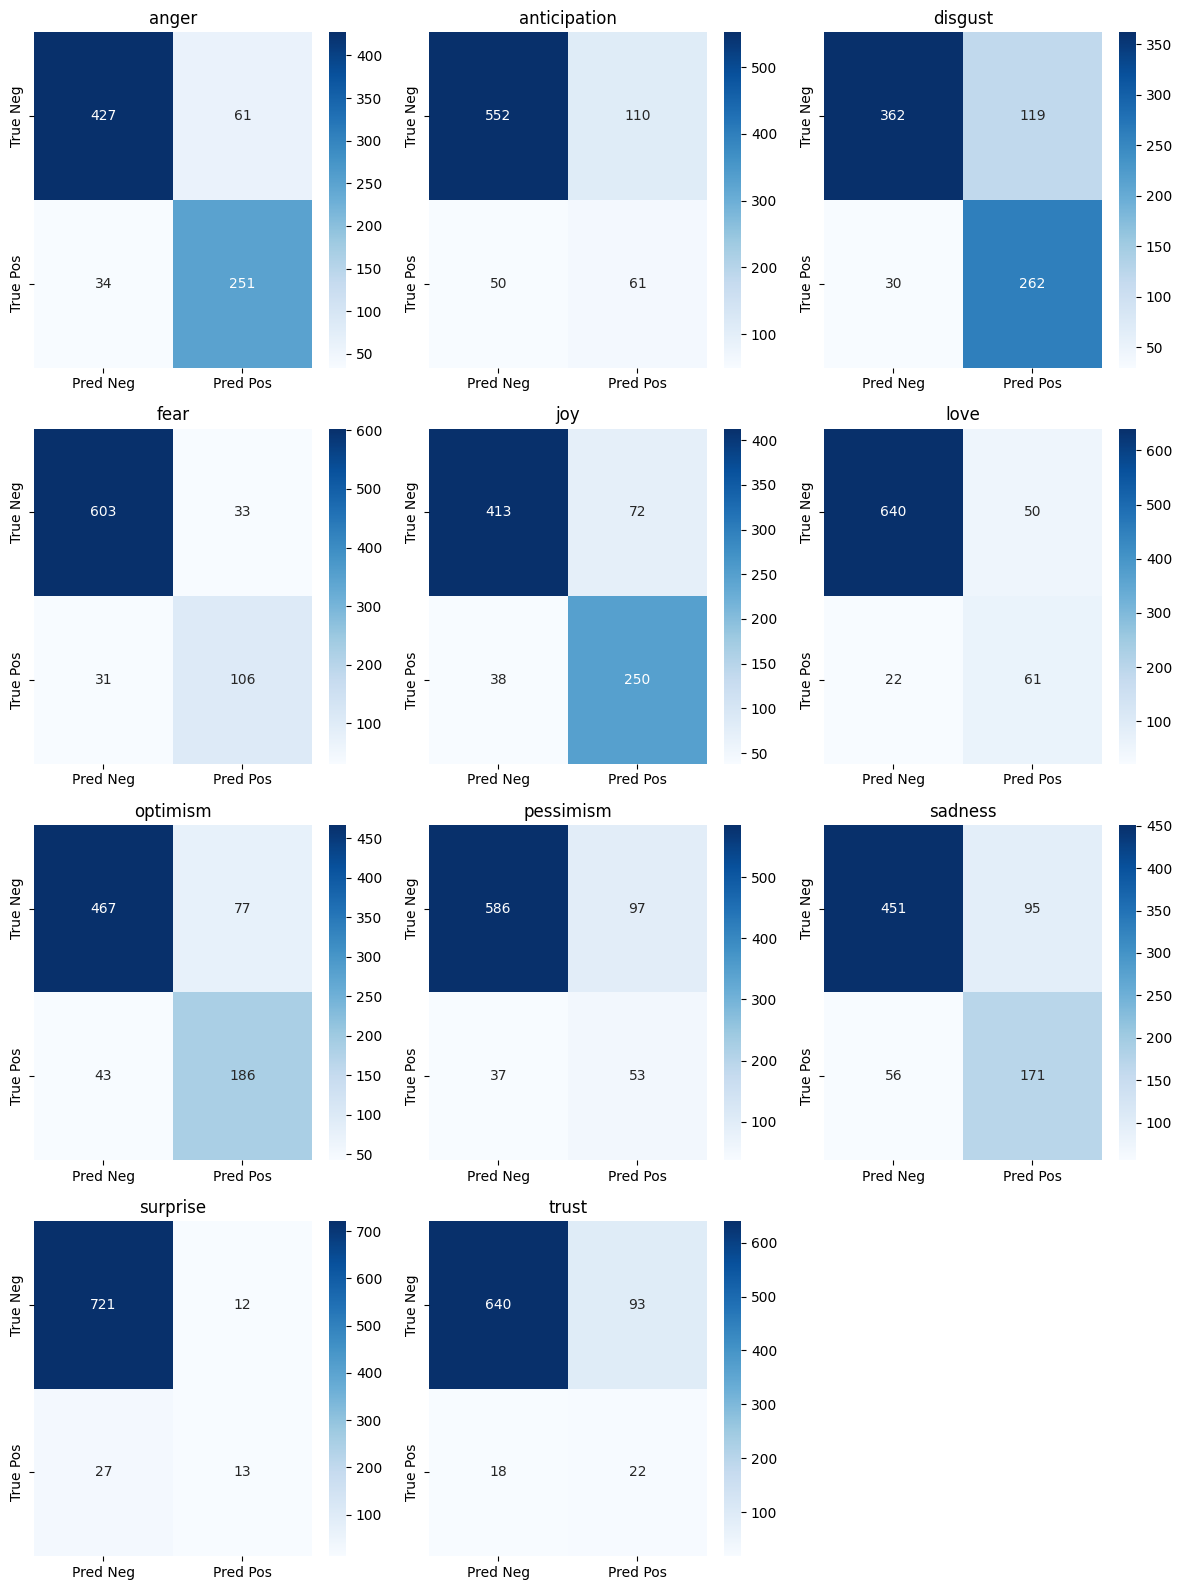

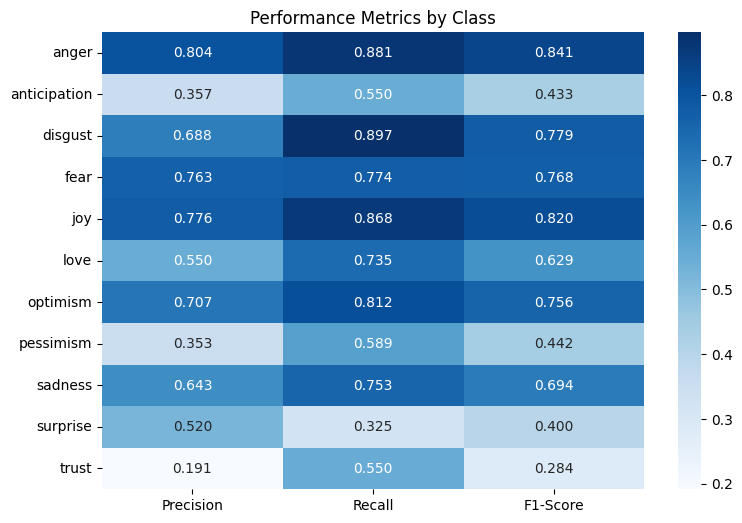

<Figure size 1200x533.333 with 0 Axes>

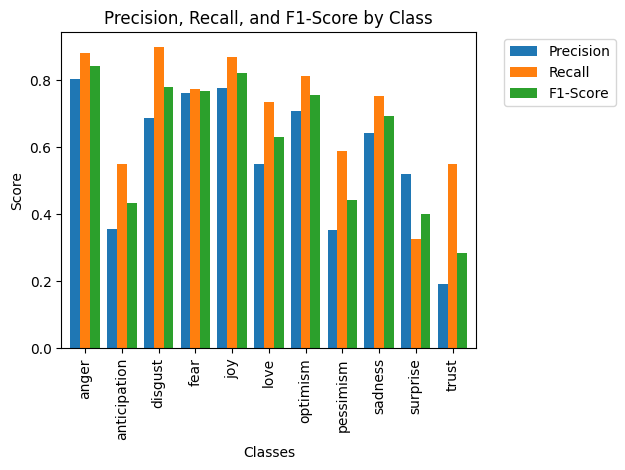

{'macro_avg': {'precision': 0.57746659267574,
  'recall': 0.7030590407381317,
  'f1': 0.6221908745166878},
 'per_class': {'Precision': {'anger': 0.8044871794871795,
   'anticipation': 0.3567251461988304,
   'disgust': 0.6876640419947506,
   'fear': 0.762589928057554,
   'joy': 0.7763975155279503,
   'love': 0.5495495495495496,
   'optimism': 0.7072243346007605,
   'pessimism': 0.35333333333333333,
   'sadness': 0.6428571428571429,
   'surprise': 0.52,
   'trust': 0.19130434782608696},
  'Recall': {'anger': 0.8807017543859649,
   'anticipation': 0.5495495495495496,
   'disgust': 0.8972602739726028,
   'fear': 0.7737226277372263,
   'joy': 0.8680555555555556,
   'love': 0.7349397590361446,
   'optimism': 0.8122270742358079,
   'pessimism': 0.5888888888888889,
   'sadness': 0.7533039647577092,
   'surprise': 0.325,
   'trust': 0.55},
  'F1-Score': {'anger': 0.8408710217755444,
   'anticipation': 0.4326241134751773,
   'disgust': 0.7786032689450223,
   'fear': 0.7681159420289855,
   'joy':

In [ ]:
multilabel_evaluation(y_true = valid_labels, y_pred = valid_preds, class_names = class_names, figsize =(12,8))

*Results Analysis*

- These results **may be the best so far** among all the models I've trained. However, it's important to note that there was some noticeable **overfitting** in this dataset. This implies that this model **may not generalize as effectively** to unseen data compared to others I've trained.

- If we examine the **primary metric (F1 score)** for each class, we can see that the model is doing a fairly good job of identifying patterns, even within the **most underrepresented classes** like *surprise* and *trust*. My previous best model was unable to detect any patterns in the *trust* class, whereas this model shows **marked improvement** in that class as well as several others.
  - This raises the question: could this improvement be due to the **proper usage of class weights** and the **fine-tuning of thresholds**, or is there another contributing factor?

- As expected, the model performs better in the **more well-represented classes** such as *disgust*, *anger*, and *joy*. The next step is to conduct **model inference** on some unseen data to evaluate how well it performs against competitors in the competition.


<font color = 'hotpink'>*Getting the best checkpoint*

In [ ]:
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f'The best model checkpoint was saved at step {best_model_checkpoint_step}.')

The best model checkpoint was saved at step 450.


In [ ]:
checkpoint = str(model_folder/f'checkpoint-450')
checkpoint

'/content/drive/MyDrive/Colab Notebooks/models/nlp_fall_2024/gemma2b/checkpoint-450'

In [ ]:
wandb.finish()

eval/accuracy_all,▁▂▂▄▄▄▄▆█▇▇█▇█
eval/accuracy_label,▁▄▅▅▆▆▆▇██████
eval/f1_macro,▁▄▆▆▇▇▆▇█▇▇▇▇█
eval/f1_micro,▁▄▆▅▆▆▆▇█▇▇███
eval/loss,▂▁▁▁▂▂▂▂▃▇▇██▃
eval/runtime,▅▃▂▁▄▃▃▃▁▃▅▃▃█
eval/samples_per_second,▄▆▇█▅▆▆▆█▆▄▆▆▁
eval/steps_per_second,▄▆▇█▅▆▆▆█▆▄▆▆▁
eval_accuracy,▁
eval_f1_macro,▁
eval_loss,▁


# <font color='hotpink'>**7. Performing Model Inference**

In [ ]:
from peft import AutoPeftModelForSequenceClassification, PeftConfig

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels = 11,
                                                           problem_type = 'multi_label_classification',
                                                           quantization_config = bnb_config,
                                                           torch_dtype = torch_data_type,
                                                           trust_remote_code = True,)

peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
model.config.use_cache = False

model.eval()
model.config.use_cache = False

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of Gemma2ForSequenceClassification were not initialized from the model checkpoint at google/gemma-2-2b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

In [ ]:
model.config

Gemma2Config {
  "_attn_implementation_autoset": true,
  "_name_or_path": "google/gemma-2-2b",
  "architectures": [
    "Gemma2ForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "attn_logit_softcapping": 50.0,
  "bos_token_id": 2,
  "cache_implementation": "hybrid",
  "eos_token_id": 1,
  "final_logit_softcapping": 30.0,
  "head_dim": 256,
  "hidden_act": "gelu_pytorch_tanh",
  "hidden_activation": "gelu_pytorch_tanh",
  "hidden_size": 2304,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10"
  },
  "initializer_range": 0.02,
  "intermediate_size": 9216,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "max_pos

In [ ]:
id2label= {id_: label_ for id_, label_ in enumerate(class_names)}
label2id = {label_: id_ for id_, label_ in enumerate(class_names)}
model.config.id2label = id2label
model.config.label2id = label2id

In [ ]:
model.config

Gemma2Config {
  "_attn_implementation_autoset": true,
  "_name_or_path": "google/gemma-2-2b",
  "architectures": [
    "Gemma2ForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "attn_logit_softcapping": 50.0,
  "bos_token_id": 2,
  "cache_implementation": "hybrid",
  "eos_token_id": 1,
  "final_logit_softcapping": 30.0,
  "head_dim": 256,
  "hidden_act": "gelu_pytorch_tanh",
  "hidden_activation": "gelu_pytorch_tanh",
  "hidden_size": 2304,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "initializer_range": 0.02,
  "intermediate_size": 9216,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "max_position_embedd

In [ ]:
free_gpu_memory()

GPU memory has been freed.


In [ ]:
custom_pipeline = pipeline(
    task = 'text-classification',
    model = model,
    tokenizer = tokenizer,
    return_all_scores = True,
    function_to_apply = 'sigmoid'
)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
# loading in the test data
test_ds = joblib.load(data_folder/'X_test_cleaned.pkl')

In [ ]:
test_df = pd.DataFrame(test_ds).T # transposing
test_df.rename(columns = {0:'text', 1:'label'}, inplace = True)
print(test_df.head())
print("-"*30)
print(test_df.shape)
print('There are no labels for the entire test set.')

                                                text  \
0  @Adnan__786__ @AsYouNotWish Dont worry Indian ...   
1  Academy of Sciences, eschews the normally sobe...   
2                  I blew that opportunity -__- #mad   
3             This time in 2 weeks I will be 30... 😥   
4  #Deppression is real. Partners w/ #depressed p...   

                                               label  
0  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
1  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
2  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
3  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
4  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
------------------------------
(3259, 2)
There are no labels for the entire test set.


In [ ]:
# performing a test to ensure the prediction pipeline is working
sample = test_df['text'][0]

preds = custom_pipeline(sample)
preds

[[{'label': 'anger', 'score': 0.6758716106414795},
  {'label': 'anticipation', 'score': 0.09551806002855301},
  {'label': 'disgust', 'score': 0.5455278754234314},
  {'label': 'fear', 'score': 0.978425920009613},
  {'label': 'joy', 'score': 0.21502088010311127},
  {'label': 'love', 'score': 0.017576880753040314},
  {'label': 'optimism', 'score': 0.6344301104545593},
  {'label': 'pessimism', 'score': 0.05070536583662033},
  {'label': 'sadness', 'score': 0.07821886986494064},
  {'label': 'surprise', 'score': 0.00023968688037712127},
  {'label': 'trust', 'score': 0.07892589271068573}]]

In [ ]:
def get_labels(pipeline_output, optimal_thresholds):
  positive_labels = []

  for pred_set in pipeline_output:
    # getting the scores for all labels
    scores = [pred['score'] for pred in pred_set]
    labels = [pred['label'] for pred in pred_set]

    # getting the positions where the score > optimal threshold
    sample_positives = [
        label for label, score, threshold in zip(labels, scores, optimal_thresholds)
        if score > threshold
    ]

    positive_labels.append(sample_positives)

  return positive_labels

In [ ]:
optimal_thresholds = [0.449634850025177,
 0.39094090461730957,
 0.28577059507369995,
 0.6334027051925659,
 0.46369385719299316,
 0.6942869424819946,
 0.47104135155677795,
 0.494217187166214,
 0.33982816338539124,
 0.8856314420700073,
 0.28418272733688354]

In [ ]:
results = get_labels(preds, optimal_thresholds)
results

[['anger', 'disgust', 'fear', 'optimism']]

<font color = 'hotpink'>*Important Note*
- In my last distilRoBERTa model there were only 3 classes predicted.

 <font color = 'hotpink'>**Final Inferencing**

- In this step I will be doing inferencing on the test set with no labels and making a submission to the Kaggle Competition.
- Based on my observations so far, this should be the best model of the competition.
- I will be using my premade function to attach the labels and make a new csv.
- At the end of this notebook I will be writing a Final Report of the model.

In [ ]:
def get_predictions_from_pipeline(pipeline_output, model, df_test_ids, optimal_thresholds):
    """
    This function processes the pipeline output using custom thresholds and generates predictions
    for the test dataset, returning a final DataFrame with test IDs and predicted labels.

    Parameters:
    - pipeline_output: The output from the custom pipeline (containing the scores)
    - model: The model used for generating the pipeline output (to get the id2labels)
    - df_test_ids: A DataFrame containing the test IDs
    - optimal_thresholds: A list of optimal thresholds for each label

    Returns:
    - df_pred_final: A pandas DataFrame with test IDs and their corresponding label predictions in binary format
    - positive_labels_list: A list of positive labels for each instance to compare results.
    """
    # 1. Get positive labels using the custom thresholds
    positive_labels_list = get_labels(pipeline_output, optimal_thresholds)

    # 2. Prepare binary predictions using the optimal thresholds
    binary_predictions = []
    for pred_set in pipeline_output:
        scores = [pred['score'] for pred in pred_set]
        binary_preds = [1 if score > threshold else 0 for score, threshold in zip(scores, optimal_thresholds)]
        binary_predictions.append(binary_preds)

    # 3. Convert the binary predictions to a DataFrame
    # Map the model config labels
    class_labels = [model.config.id2label[i] for i in range(len(model.config.id2label))]
    df_predictions = pd.DataFrame(binary_predictions, columns=class_labels)

    # 4. Concatenate test IDs with predictions
    df_pred_final = pd.concat([df_test_ids.reset_index(drop=True), df_predictions], axis=1)

    # 5. Set the index of the final DataFrame to be the ID column
    df_pred_final = df_pred_final.set_index('ID')

    return df_pred_final, positive_labels_list


In [ ]:
test_ids = joblib.load(data_folder/'test_ids.pkl')
test_ids.head()

,ID
0,2018-01559
1,2018-03739
2,2018-00385
3,2018-03001
4,2018-01988


<font color = 'hotpink'>***Prepping the test_df to make predictions***

In [ ]:
test_ds = test_df.drop(columns = {'label'}) # dropping the missing labels from the test dataset

In [ ]:
test_ds

,text
0,@Adnan__786__ @AsYouNotWish Dont worry Indian ...
1,"Academy of Sciences, eschews the normally sobe..."
2,I blew that opportunity -__- #mad
3,This time in 2 weeks I will be 30... 😥
4,#Deppression is real. Partners w/ #depressed p...
...,...
3254,shaft abrasions from panties merely shifted to...
3255,@lomadia heard of Remothered? Indie horror gam...
3256,All this fake outrage. Y'all need to stop 🤣
3257,Would be ever so grateful if you could record ...


In [ ]:
test_ds = Dataset.from_pandas(test_ds)

In [ ]:
test_ds['text'][0:3]

['@Adnan__786__ @AsYouNotWish Dont worry Indian army is on its ways to dispatch all Terrorists to Hell',
 'Academy of Sciences, eschews the normally sober tone of scientific papers and calls the massive loss of wildlife a “biological annihilation',
 'I blew that opportunity -__- #mad']

In [ ]:
# input for the function written above
pipeline_output = custom_pipeline(test_ds['text'][:]) # running the prediction pipeline on all documents

In [ ]:
df_pred_final, positive_labels_list = get_predictions_from_pipeline(pipeline_output = pipeline_output,
                                                                    model = model,
                                                                    df_test_ids = test_ids, optimal_thresholds = optimal_thresholds)

In [ ]:
df_pred_final.sum()

,0
anger,1157
anticipation,558
disgust,1396
fear,469
joy,1599
love,635
optimism,1301
pessimism,602
sadness,1170
surprise,77


In [ ]:
df_pred_final.shape

(3259, 11)

In [ ]:
df_pred_final.to_csv(base_folder/'final_predictions_gemma-2b.csv')